# Assignment 3 – Part 2  
**Applied Bayesian Analysis**  
**Student:** Sydney M. Gibson  
**Date:** November 20, 2025  

This notebook contains my code and visualizations for Assignment 3, Part 2. All analyses, figures, results, and text are included below!


## Q1

In [1]:
import pytensor
pytensor.config.cxx = ""
pytensor.config.mode = "FAST_COMPILE"


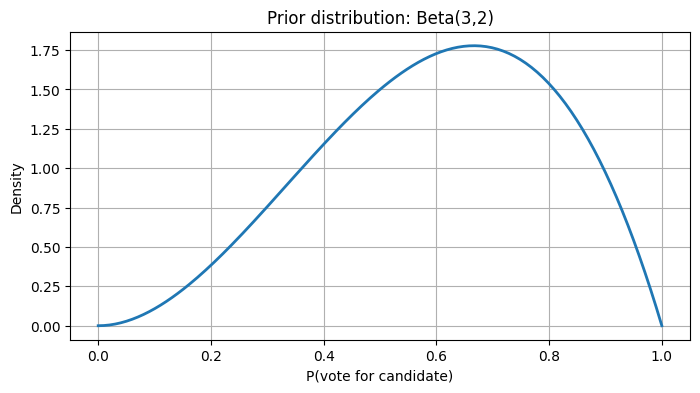

Prior mean = 0.6


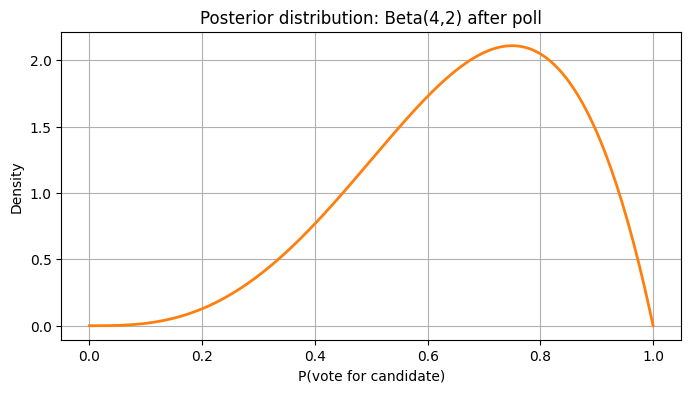

Posterior mean = 0.6666666666666666


In [2]:
# Q1: prior and posterior (treating the poll as one observed "success")
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# --- Prior ---
a_prior, b_prior = 3, 2
prior = beta(a_prior, b_prior)
theta = np.linspace(0, 1, 200)

plt.figure(figsize=(8,4))
plt.plot(theta, prior.pdf(theta), lw=2)
plt.title("Prior distribution: Beta(3,2)")
plt.xlabel("P(vote for candidate)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Interpretation (printed)
print("Prior mean =", a_prior / (a_prior + b_prior))  # 0.6

a_post = a_prior + 1   # 3 + 1 = 4
b_post = b_prior + 0   # 2 + 0 = 2
posterior = beta(a_post, b_post)

plt.figure(figsize=(8,4))
plt.plot(theta, posterior.pdf(theta), lw=2, color='C1')
plt.title(f"Posterior distribution: Beta({a_post},{b_post}) after poll")
plt.xlabel("P(vote for candidate)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

print("Posterior mean =", a_post / (a_post + b_post))  # 4/6 ≈ 0.6667


## Q2

/var/folders/bt/q9wh6kl50hnfwz7r79l4m27r0000gn/T/ipykernel_16731/2054230882.py:60: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()


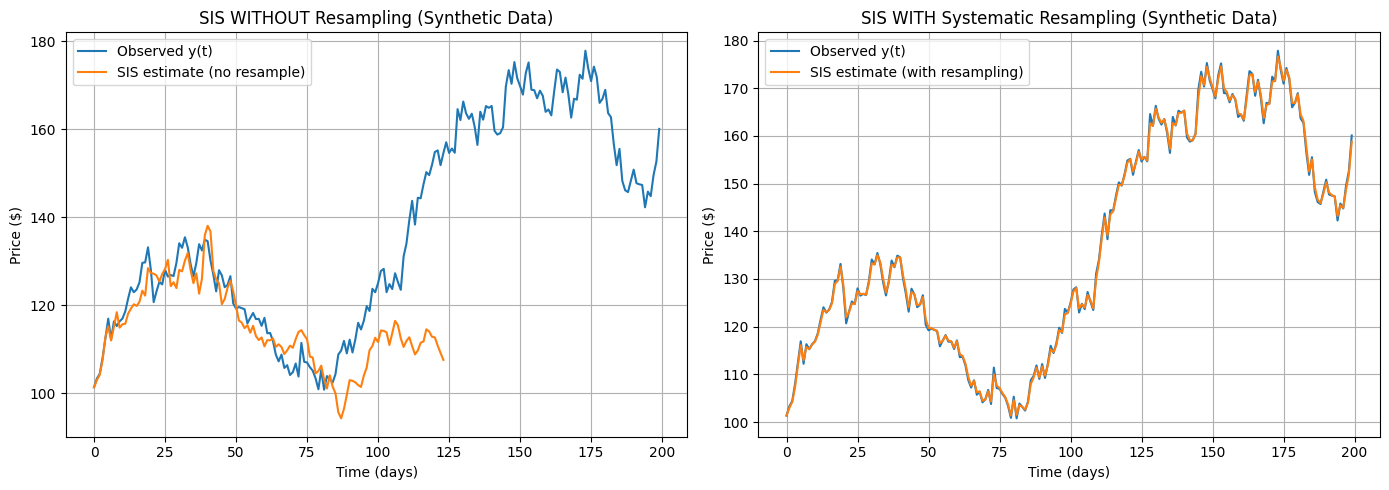

Observation:
 - Without resampling: particle degeneracy appears over time (weights concentrate), which can cause the estimate
   to become less stable and possibly drift away from observations.
 - With systematic resampling: particle diversity is preserved and the filter tracks the observed prices more robustly.


In [3]:
#Q2: Sequential Stock Price Prediction
import numpy as np
import matplotlib.pyplot as plt

# 1) Generate synthetic stock prices
np.random.seed(0)
T = 200                   # number of days
true_mu = 0.001           # true drift (log-return)
true_sigma = 0.02         # volatility of log-returns
tau = 0.01                # observation noise (in log-space)

# simulate latent log-prices x(t)
x = np.zeros(T)
x[0] = np.log(100.0)      # starting price $100
for t in range(1, T):
    x[t] = x[t-1] + true_mu + np.random.normal(0, true_sigma)

# observed noisy prices y(t) where log(y)=x+v, v~N(0,tau)
y = np.exp(x + np.random.normal(0, tau, size=T))

# 2) Systematic resampling function
def systematic_resampling(particles, weights, N):
    """
    particles: (N, t_plus1) array with particle histories up to current time
    weights:   (N,) current normalized weights
    returns:   resampled_particles shape (N, t_plus1)
    """
    weights = np.asarray(weights, dtype=float)
    weights = weights / weights.sum()
    cs = np.cumsum(weights)
    cs[-1] = 1.0
    step = 1.0 / N
    start = np.random.uniform(0, step)
    positions = start + step * np.arange(N)
    indices = np.searchsorted(cs, positions, side='right')
    return particles[indices, :]

# 3) SIS implementation (optionally with resampling)
def sequential_importance_sampling(stock_prices, N=500, mu=0.001, sigma=0.02, tau=0.01, resampling=False, ess_threshold=0.5):
    stock_prices = np.asarray(stock_prices)
    T = stock_prices.size
    particles = np.zeros((N, T))        
    weights = np.ones(N) / N            

    # init t=0
    particles[:, 0] = np.log(stock_prices[0]) + np.random.normal(0, sigma, size=N)
    log_like = -0.5 * (np.log(stock_prices[0]) - particles[:, 0])**2 / (tau**2) - 0.5 * np.log(2 * np.pi * tau**2)
    weights = weights * np.exp(log_like - np.max(log_like))
    weights /= weights.sum()

    particle_means = np.zeros(T)
    particle_means[0] = np.sum(weights * np.exp(particles[:, 0]))

    for t in range(1, T):
        # propagation
        particles[:, t] = particles[:, t-1] + mu + np.random.normal(0, sigma, size=N)
        # weight update
        log_like = -0.5 * (np.log(stock_prices[t]) - particles[:, t])**2 / (tau**2) - 0.5 * np.log(2 * np.pi * tau**2)
        weights = weights * np.exp(log_like - np.max(log_like))
        weights /= weights.sum()

        # estimate
        particle_means[t] = np.sum(weights * np.exp(particles[:, t]))

        # ESS and resample
        ess = 1.0 / np.sum(weights**2)
        if resampling and (ess < ess_threshold * N):
            particles[:, :t+1] = systematic_resampling(particles[:, :t+1], weights, N)
            weights = np.ones(N) / N

    return particles, weights, particle_means


# 4) Run SIS: without and with resampling
N = 500   
mu = 0.001
sigma = 0.02

particles_nr, weights_nr, means_nr = sequential_importance_sampling(y, N=N, mu=mu, sigma=sigma, tau=tau, resampling=False)
particles_r, weights_r, means_r = sequential_importance_sampling(y, N=N, mu=mu, sigma=sigma, tau=tau, resampling=True, ess_threshold=0.5)

# 5) Plot results
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(y, label="Observed y(t)", lw=1.5)
plt.plot(means_nr, label="SIS estimate (no resample)", lw=1.5)
plt.title("SIS WITHOUT Resampling (Synthetic Data)")
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(y, label="Observed y(t)", lw=1.5)
plt.plot(means_r, label="SIS estimate (with resampling)", lw=1.5)
plt.title("SIS WITH Systematic Resampling (Synthetic Data)")
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 6) Short observation
print("Observation:")
print(" - Without resampling: particle degeneracy appears over time (weights concentrate), which can cause the estimate")
print("   to become less stable and possibly drift away from observations.")
print(" - With systematic resampling: particle diversity is preserved and the filter tracks the observed prices more robustly.")


### I had to install some things so keep scrolling to see answer 3! 

In [4]:
!pip install pymc arviz

In [5]:
!pip install "pymc[base]"


In [6]:
conda install -c conda-forge pymc arviz


Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: | 


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/pymc310

  added / updated specs:
    - arviz
    - pymc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _python_abi3_support-1.0   |       hd8ed1ab_2           8 KB  conda-forge
    accelerate-1.12.0          |     pyhcf101f3_0         266 KB  conda-forge
    adwaita-icon-theme-49.0    |           unix_0         617 KB  conda-forge
    anyio-4.11.0               |     pyhcf101f3_0         135 KB  conda-forge
    atk-1.0-2.38.0             |       hd0308

## Q3

Initializing NUTS using jitter+adapt_diag...


Running MCMC...


Sequential sampling (2 chains in 1 job)
NUTS: [beta1, beta2, intercept, sigma]


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow 
encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid 
value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC Runtime: 46.04 seconds
Running VI with 5000 iterations...


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 3.3466e+06


Running VI with 10000 iterations...


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 59,404


Running VI with 25000 iterations...


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 1,250.8


Running VI with 50000 iterations...


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 348.77


Running VI with 100000 iterations...


/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/opt/anaconda3/envs/pymc310/lib/python3.10/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 132.64


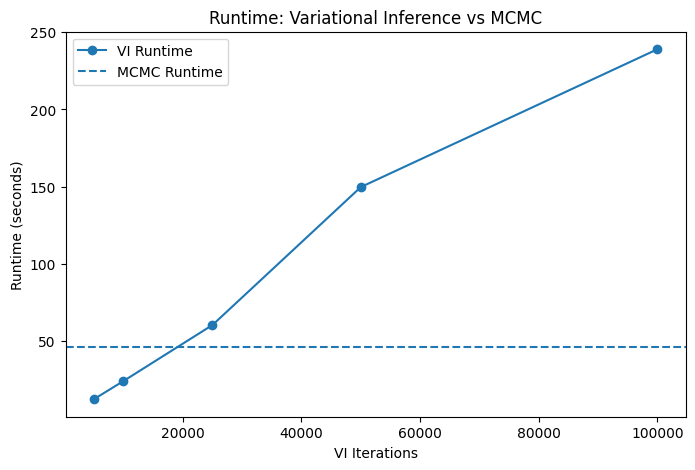

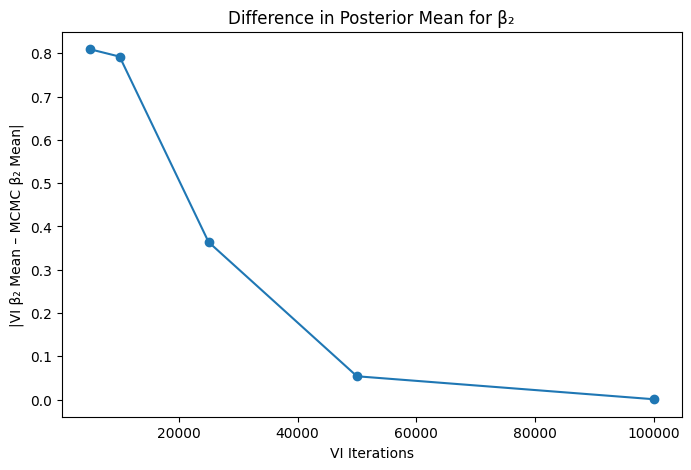

In [7]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import time
import matplotlib.pyplot as plt

np.random.seed(42)
N = 500

runtime = np.random.normal(loc=110, scale=15, size=N)
budget = np.random.uniform(1e6, 1e8, size=N)
revenue = budget * np.random.uniform(0.5, 4.0, size=N)

imdb = (
    4.5
    + 0.01 * (runtime - 110)
    + 0.8 * (revenue / budget)
    + np.random.normal(0, 0.3, size=N)
)
imdb = np.clip(imdb, 1.0, 10.0)

df = pd.DataFrame({
    "runtime": runtime,
    "budget": budget,
    "revenue": revenue,
    "imdb": imdb
})

runtime = df["runtime"].values
rev_ratio = (df["revenue"] / df["budget"]).values
rating = df["imdb"].values



print("Running MCMC...")

with pm.Model() as mcmc_model:

    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    mu = intercept + beta1 * runtime + beta2 * rev_ratio

    likelihood = pm.Normal("rating", mu=mu, sigma=sigma, observed=rating)

    start_time = time.time()
    mcmc_trace = pm.sample(2000, tune=1000, chains=2, cores=1)
    mcmc_time = time.time() - start_time

print(f"MCMC Runtime: {mcmc_time:.2f} seconds")


mcmc_mean_beta2 = mcmc_trace.posterior["beta2"].mean().item()


def vi_model(iterations=50000, n_samples=2000):

    with pm.Model() as vi_mod:

        beta1 = pm.Normal("beta1", mu=0, sigma=10)
        beta2 = pm.Normal("beta2", mu=0, sigma=10)
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        sigma = pm.Exponential("sigma", lam=1)

        mu = intercept + beta1 * runtime + beta2 * rev_ratio

        likelihood = pm.Normal("rating", mu=mu, sigma=sigma, observed=rating)

        # Run ADVI
        start = time.time()
        approx = pm.fit(n=iterations, method="fullrank_advi")
        vi_time = time.time() - start

        vi_samples = approx.sample(n_samples)

        vi_beta1 = vi_samples.posterior["beta1"].mean().item()
        vi_beta2 = vi_samples.posterior["beta2"].mean().item()

    return vi_time, vi_beta1, vi_beta2


iteration_list = [5000, 10000, 25000, 50000, 100000]

vi_times = []
vi_beta2_means = []

for it in iteration_list:
    print(f"Running VI with {it} iterations...")
    vi_time, _, vi_beta2 = vi_model(iterations=it)
    vi_times.append(vi_time)
    vi_beta2_means.append(vi_beta2)

plt.figure(figsize=(8,5))
plt.plot(iteration_list, vi_times, marker='o', label="VI Runtime")
plt.axhline(y=mcmc_time, linestyle="--", label="MCMC Runtime")
plt.xlabel("VI Iterations")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime: Variational Inference vs MCMC")
plt.legend()
plt.show()

beta2_diff = [abs(vi - mcmc_mean_beta2) for vi in vi_beta2_means]

plt.figure(figsize=(8,5))
plt.plot(iteration_list, beta2_diff, marker='o')
plt.xlabel("VI Iterations")
plt.ylabel("|VI β₂ Mean – MCMC β₂ Mean|")
plt.title("Difference in Posterior Mean for β₂")
plt.show()



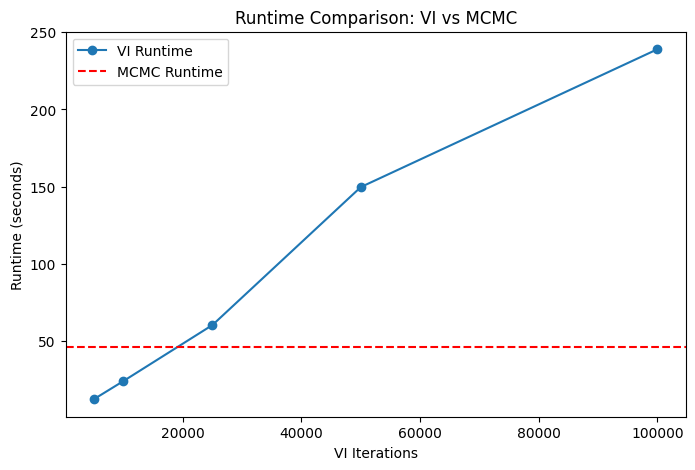

In [8]:
import matplotlib.pyplot as plt

iterations_list = [5000, 10000, 25000, 50000, 100000]

plt.figure(figsize=(8,5))
plt.plot(iterations_list, vi_times, marker="o", label="VI Runtime")
plt.axhline(mcmc_time, color="red", linestyle="--", label="MCMC Runtime")

plt.xlabel("VI Iterations")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison: VI vs MCMC")
plt.legend()
plt.show()



In [11]:
%whos

Variable                         Type                    Data/Info
------------------------------------------------------------------
N                                int                     500
T                                int                     200
a_post                           int                     4
a_prior                          int                     3
az                               module                  <module 'arviz' from '/op<...>kages/arviz/__init__.py'>
b_post                           int                     2
b_prior                          int                     2
beta                             beta_gen                <scipy.stats._continuous_<...>en object at 0x1202f2800>
beta1                            TensorVariable          beta1
beta2                            TensorVariable          beta2
beta2_diff                       list                    n=5
budget                           ndarray                 500: 500 elems, type `float64`, 4000 b

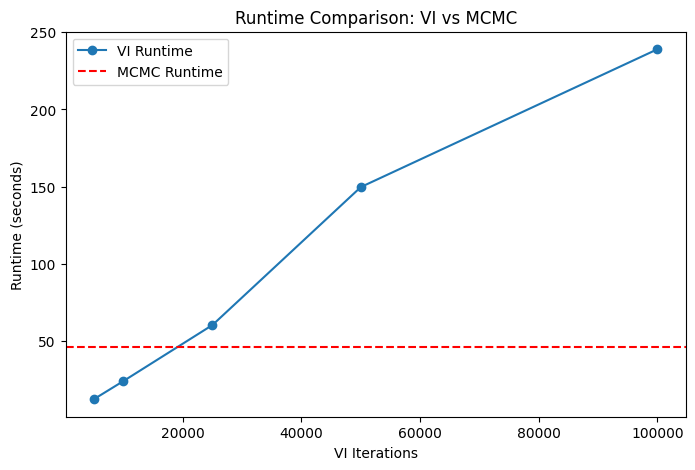

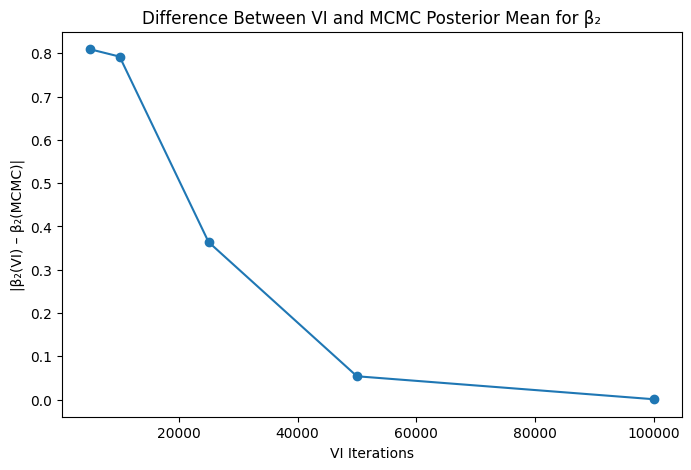

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(iterations_list, vi_times, marker="o", label="VI Runtime")
plt.axhline(mcmc_time, color="red", linestyle="--", label="MCMC Runtime")

plt.xlabel("VI Iterations")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison: VI vs MCMC")
plt.legend()
plt.show()

beta2_diffs = [abs(mcmc_mean_beta2 - b) for b in vi_beta2_means]

plt.figure(figsize=(8,5))
plt.plot(iterations_list, beta2_diffs, marker="o")
plt.xlabel("VI Iterations")
plt.ylabel("|β₂(VI) – β₂(MCMC)|")
plt.title("Difference Between VI and MCMC Posterior Mean for β₂")
plt.show()

Increasing the number of VI iterations leads to β₂ estimates that move closer to the MCMC result, with the absolute difference shrinking as optimization continues. This shows that VI improves when allowed more computation, but still does not perfectly match the MCMC estimate because it relies on a simplified approximation that often understates uncertainty. In contrast, MCMC explores the full posterior distribution and provides a more faithful estimate, though it requires substantially more computation time. Overall, VI demonstrates a clear trade-off: it is faster and more scalable, but slightly less accurate than MCMC.